In [1]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
# change plot size
library(repr)
options(repr.plot.width=8, repr.plot.height=6)

In [4]:
##  Pull in the packages required to perform our analyis
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(sqldf))
suppressPackageStartupMessages(library(forcats))

In [88]:
## Read in our clustered sample data set - suppressing message to remove unnecessary text


suncountry <- suppressMessages(readr::read_csv(file = "SunCountry_MSPDepartures_20kSample_wCluster.csv"))

In [4]:
## View the first few rows to see the structure of the data

head(suncountry)

id,ServiceStartCity,ServiceEndCity,GenderCode,BookingChannel,TimeGap,TripMonth,Age,UflyMember,CardHolderFlag,cluster
1,MSP,SAN,F,Outside Booking,27,December,21,0,0,1
2,MSP,DFW,M,SCA Website Booking,20,October,45,1,0,2
3,MSP,SEA,F,Outside Booking,63,December,63,0,0,3
4,MSP,SEA,F,SCA Website Booking,63,August,39,0,0,4
5,MSP,ANC,F,Outside Booking,137,July,25,0,0,3
6,MSP,CUN,M,Outside Booking,24,December,21,0,0,1


In [5]:
## View some summary statistics of the clustered dataset

summary(suncountry)

       id        ServiceStartCity   ServiceEndCity      GenderCode       
 Min.   :    1   Length:20000       Length:20000       Length:20000      
 1st Qu.: 5001   Class :character   Class :character   Class :character  
 Median :10000   Mode  :character   Mode  :character   Mode  :character  
 Mean   :10000                                                           
 3rd Qu.:15000                                                           
 Max.   :20000                                                           
 BookingChannel        TimeGap        TripMonth              Age        
 Length:20000       Min.   :  0.00   Length:20000       Min.   :  0.00  
 Class :character   1st Qu.: 20.00   Class :character   1st Qu.: 26.00  
 Mode  :character   Median : 46.00   Mode  :character   Median : 42.00  
                    Mean   : 63.35                      Mean   : 40.71  
                    3rd Qu.: 89.00                      3rd Qu.: 55.00  
                    Max.   :650.00          

In [6]:
## Generate some quick tables to view categorical variables and their distributions

table(suncountry$ServiceStartCity)
table(suncountry$ServiceEndCity)

table(suncountry$TripMonth)

table(suncountry$GenderCode)

table(suncountry$UflyMember)

table(suncountry$CardHolderFlag)

table(suncountry$cluster)


  MSP 
20000 


 ANC  BOS  CUN  CZM  DCA  DFW  GRB  HRL  HUX  IFP  JFK  LAN  LAS  LAX  LIR  MBJ 
 249 1121 1048  112  614  706    3  386   35   10 1414  303 2550 1347   68  132 
 MCO  MDW  MIA  MZT  PHX  PNS  PSP  PUJ  PVR  RSW  SAN  SEA  SFO  SJD  SJU  STT 
1939  556  217   81  871    3  526  209  368 1293  642 1164 1308  138   58   78 
 SXM  TPA  ZIH 
  72  283   96 


    April    August  December  February   January      July      June     March 
     1466      1468      2039      2074      1632      1596      1493      2726 
      May  November   October September 
     1416      1398      1631      1061 


    F     M     U 
10479  9520     1 


    0     1 
15406  4594 


    0     1 
19770   230 


   1    2    3    4    5    6 
4001 1905 4212 3800 3720 2362 

For our sample subset of data (20000 rows), here's what we observe:

1.  All trips start from MSP (no real surprise here)
2.  A pretty wide spread of final destinations, we'll do some counts by cluster to see where these groups are flying
3.  About an even split between Female and Male passengers, the one U we will remove for the visualization
4.  Trips are pretty evenly split across the months, but let's see if we can focus on certain times of year
5.  Vast majority are NOT UFly Members, and not credit card holders
6.  Pretty evenly split amongst the different clusters

In [43]:
## Let's look at some basic plots for each customer segment

In [30]:
## Taking one extra step here to filter out the one row with U for the Gender Analysis
suncountry <- suncountry %>% filter(GenderCode != 'U')

## Set cluster as the customer segment and also make it at factor

suncountry$cluster <- as.factor(suncountry$cluster)

In [8]:
table(suncountry$GenderCode)


    F     M 
10479  9520 

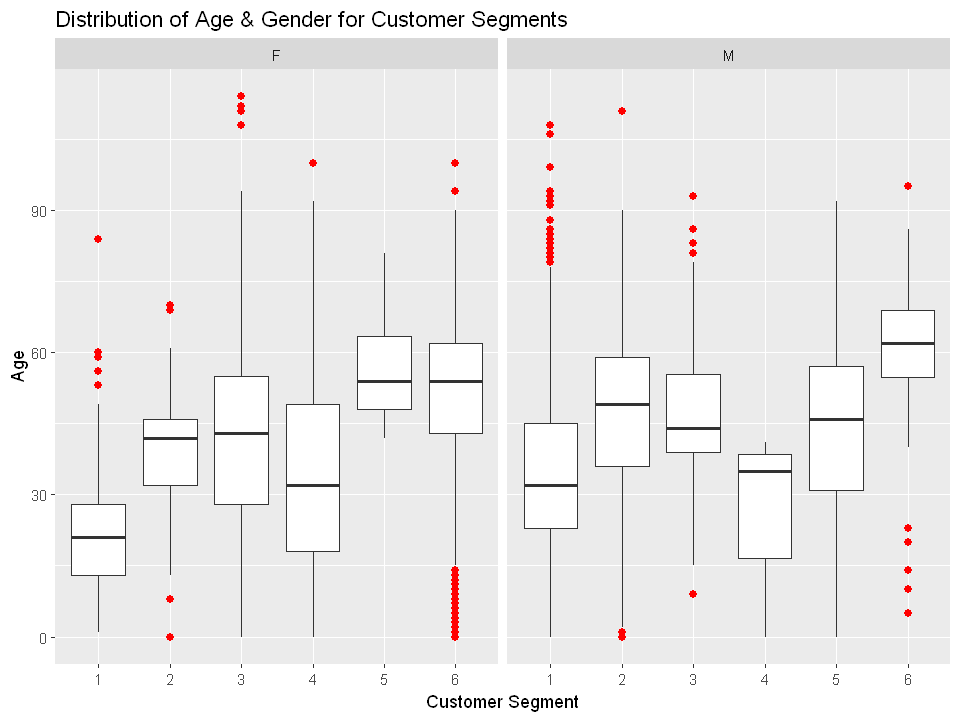

In [76]:
## Distributions for Age based on the customer segment - we see a lot of outliers

ggplot(suncountry, aes(x = cluster, y = Age)) +
        geom_boxplot(outlier.colour="red", outlier.size=2) + facet_grid(. ~ GenderCode) +
        labs(x="Customer Segment", title = "Distribution of Age & Gender for Customer Segments")

In [66]:
## Distributions of Final Destinations for Each Customer Segment

customer_segment_final_destination <- suncountry %>% 
        
        ## Group by the cluster and end city
        group_by(cluster, ServiceEndCity) %>%
        ## Count the number of times each end city appears
        summarise(id = n()) %>%
        ## Grab the top 10 final destinations for each to make for easier plotting
        top_n(10)

## Now we pivot the table a bit so that we organize by the final destinations for each segment - we'll use this in the next plot
final_dest_total_trips <- customer_segment_final_destination %>% 
        group_by(ServiceEndCity, cluster) %>%
        summarise(total_trips = sum(id))

Selecting by id


In [71]:
## Generate a table showing the grand total for each final desination

sorted_table <- final_dest_total_trips %>%
        group_by(ServiceEndCity) %>%
        summarise(grand_total = sum(total_trips)) %>%
        arrange(desc(grand_total))


levels = sorted_table$ServiceEndCity

## Re-arranging the sort order for our final destionation to help generate a more understandable graphic
final_dest_total_trips$ServiceEndCity <- factor(final_dest_total_trips$ServiceEndCity, levels = levels)

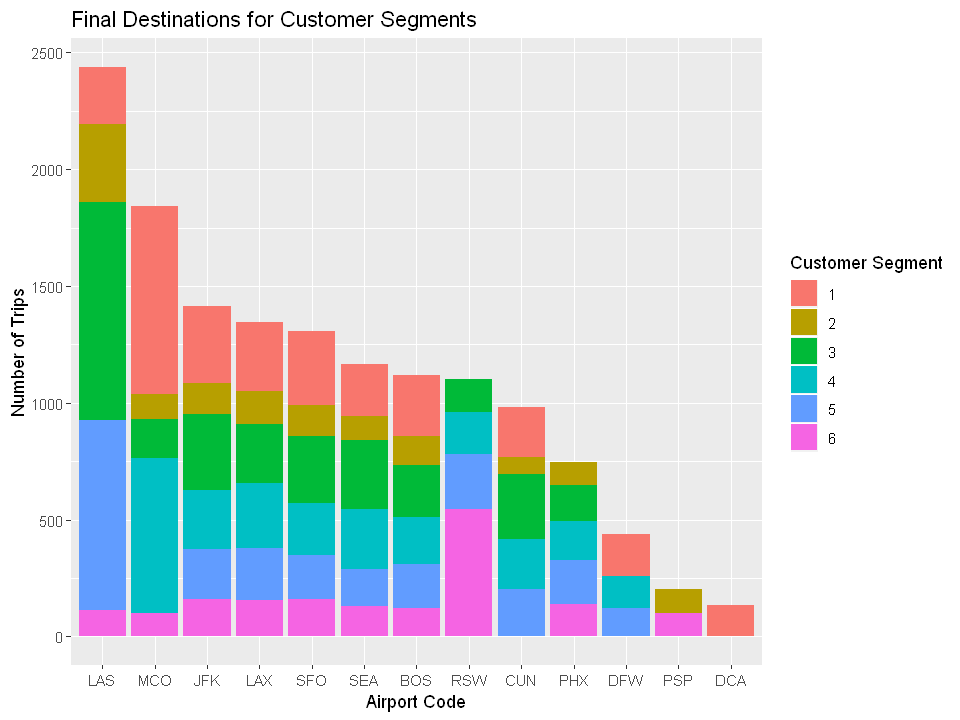

In [75]:
ggplot(final_dest_total_trips) +
        aes(x = ServiceEndCity, fill = cluster, weight = total_trips) +
        geom_bar() +
        scale_fill_hue() +
        labs(x = "Airport Code", y = "Number of Trips", title = "Final Destinations for Customer Segments", fill = "Customer Segment")

In [143]:
## Visualize how these flights were booked

## Group by booking channel and cluster

customer_segments_booking_channel <-
        suncountry %>%
                group_by(BookingChannel, cluster) %>%
                summarise(booking_count = n()) %>%
                arrange(desc(booking_count))

## Observe the first few rows
head(customer_segments_booking_channel)

BookingChannel,cluster,booking_count
Outside Booking,3,3356
Outside Booking,1,3239
SCA Website Booking,4,2841
SCA Website Booking,5,2587
SCA Website Booking,6,1836
SCA Website Booking,2,1337


In [145]:
sorted_booking_channel <- customer_segments_booking_channel %>%
        group_by(BookingChannel) %>%
        summarise(grand_total = sum(booking_count)) %>%
        arrange((grand_total))

levels = sorted_booking_channel$BookingChannel

## Re-arranging the sort order for our final destionation to help generate a more understandable graphic
customer_segments_booking_channel$BookingChannel <- factor(customer_segments_booking_channel$BookingChannel, levels = levels)

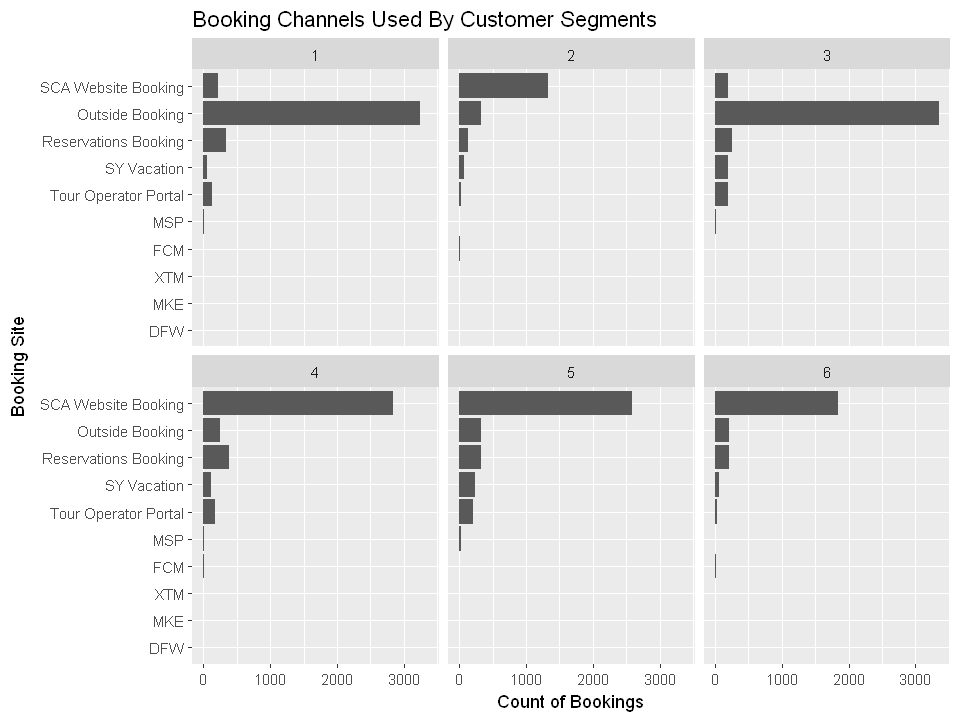

In [153]:
## Interesting observation - we see that customer segments 1 and 3 predominately used outside booking channels
## Customer Segments 4 & 5 used the Sun Country website

ggplot(customer_segments_booking_channel) +
        aes(x = BookingChannel, weight = booking_count) +
        geom_bar() +
        scale_fill_hue() +
        coord_flip() +
        labs(x = "Booking Site", y = "Count of Bookings", title = "Booking Channels Used By Customer Segments", fill = "Customer Segment") +
        facet_wrap(cluster ~ .)

In [ ]:
## Next step - UFlyMembership & CardHolders

In [5]:
customer_segment_ufly_cardholders <-

suncountry %>%
        group_by(UflyMember, CardHolderFlag, cluster) %>%
        summarise(grp_count = n()) %>%
        arrange(desc(grp_count))

In [9]:
## Convert UFlyMember column to factor variable
customer_segment_ufly_cardholders$UflyMember <- as.factor(customer_segment_ufly_cardholders$UflyMember)

customer_segment_ufly_cardholders$CardHolderFlag <- as.factor(customer_segment_ufly_cardholders$CardHolderFlag)

customer_segment_ufly_cardholders <-
        customer_segment_ufly_cardholders %>%
                mutate(UflyMember_Factor = fct_recode(UflyMember,
                        "UFly Members" = "1",
                        "Potential UFly Members" = "0")) %>%
                mutate(CardHolder_Factor = fct_recode(CardHolderFlag,
                        "Credit Card Holders" = "1",
                        "Potential CC Customers" = "0"))

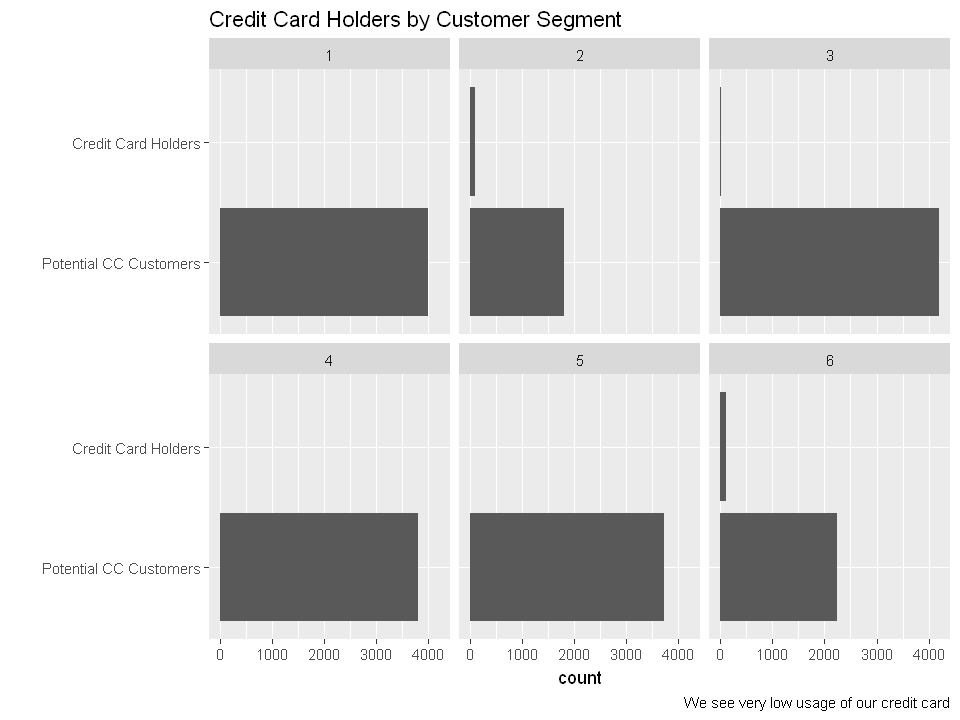

In [17]:
## Not very informative

ggplot(customer_segment_ufly_cardholders) +
 aes(x = CardHolder_Factor, weight = grp_count) +
 geom_bar() +
 labs(x = "", title = "Credit Card Holders by Customer Segment", caption = "We see very low usage of our credit card") +
 coord_flip() +
 facet_wrap(vars(cluster))

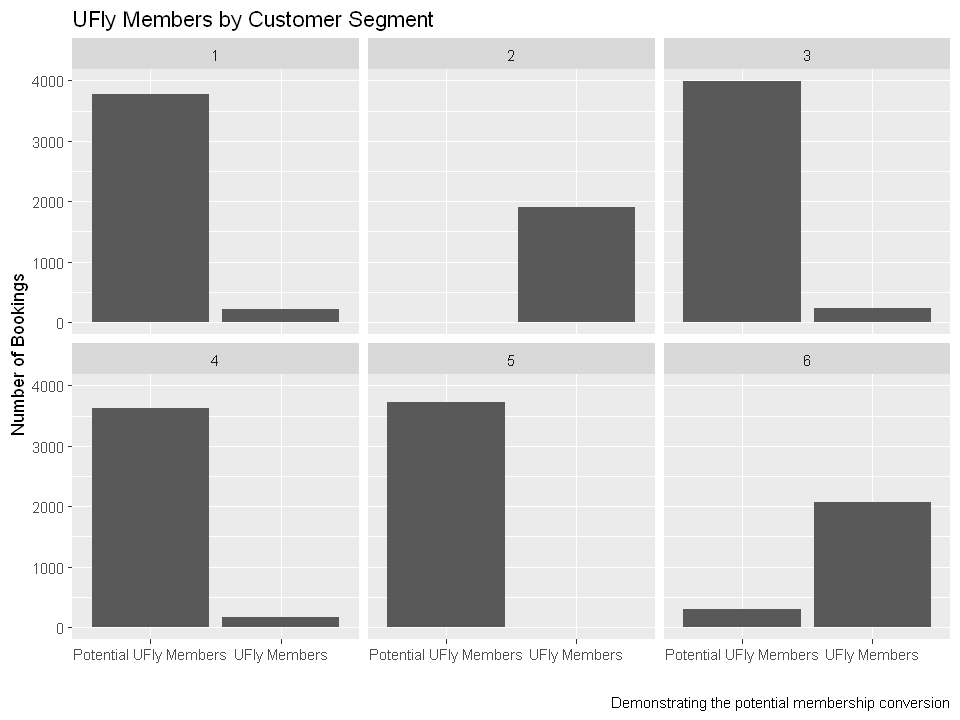

In [24]:
ggplot(customer_segment_ufly_cardholders) +
 aes(x = UflyMember_Factor, weight = grp_count) +
 geom_bar() +
 labs(x = "", title = "UFly Members by Customer Segment", y = "Number of Bookings", caption = "Demonstrating the potential membership conversion") +
 theme_gray() +
 facet_wrap(vars(cluster))

In [ ]:
#1 & 3 - avoid

#4 & 5 - what is their demographic info?

In [5]:
## So we noticed some interesting things based on the descriptive analysis of our clusters
## 4 & 5 predominately booked through the Sun Country site, but barely have any UFly Membership... Maybe we can target them?
## Let's see this separate groups by themselves
## And look at what trips they are taking, their demographic splits, and age

cluster_group_subset <-
        suncountry %>%
                filter(cluster == 4 | cluster == 5)

In [6]:
## Grouping by cluster, Gender, ServiceCity, Age

desired_cluster_by_gender_city_age <-
            cluster_group_subset %>%
                    group_by(cluster, GenderCode, ServiceEndCity, Age) %>%
                    summarise(trip_count = n()) %>%
                    arrange(desc(trip_count))

In [7]:
head(desired_cluster_by_gender_city_age, 20)

cluster,GenderCode,ServiceEndCity,Age,trip_count
5,M,LAS,50,24
5,M,LAS,54,24
4,F,MCO,37,21
5,M,LAS,43,21
5,M,LAS,44,21
5,M,LAS,48,21
5,M,LAS,53,20
4,F,MCO,18,19
5,M,LAS,51,18
5,M,LAS,56,18


In [8]:
## Now group by the other two clusters identified - the ones that did not use our booking site

target_cluster_group_subset_outside_channels <-
        suncountry %>%
                filter(cluster == 1 | cluster == 3)

## Where are they heading?

target_cluster_group_subset_outside_channels <- 
        target_cluster_group_subset_outside_channels %>%
                group_by(cluster, GenderCode, ServiceEndCity, Age) %>%
                            summarise(trip_count = n()) %>%
                            arrange(desc(trip_count))

In [9]:
head(target_cluster_group_subset_outside_channels, 20)

cluster,GenderCode,ServiceEndCity,Age,trip_count
3,F,LAS,27,32
3,F,LAS,32,29
3,F,LAS,29,25
3,F,LAS,41,25
1,M,MCO,5,24
3,F,LAS,28,24
3,F,LAS,39,24
3,F,LAS,25,22
1,M,LAS,33,21
3,F,LAS,24,21


In [ ]:
## Read in the whole dataset

## age, gender, ufly status, location, and travel time of year

## Then filter on just these ages, flights, 

In [ ]:
## Using this code snippet that Anthony created for creating the clusters so that I can go through the same process

In [5]:
## Took about 5 minutes to load the whole dataframe - don't do that again

data.dir = "C:/Users/monca016/Documents/Fall 2019/MSBA 6410 - Exploratory Analytics/HW2/SunCountry.csv"

data = read.csv(data.dir)

#parse data------------------------------------------------------------------
data = data %>% filter(MarketingAirlineCode == "SY") %>% select(TicketNum, PNRLocatorID, CouponSeqNbr, ServiceStartCity,ServiceEndCity, PNRCreateDate, ServiceStartDate, GenderCode,
                Age, PostalCode, BkdClassOfService, TrvldClassOfService, BookingChannel, BaseFareAmt, TotalDocAmt, UflyMemberStatus,
                CardHolder, BookedProduct, EnrollDate, StopoverCode)

In [6]:
head(data)

TicketNum,PNRLocatorID,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,GenderCode,Age,PostalCode,BkdClassOfService,TrvldClassOfService,BookingChannel,BaseFareAmt,TotalDocAmt,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,StopoverCode
3.377365e+12,AAABJK,2,JFK,MSP,2013-11-23,2013-12-13,F,66,,Coach,Coach,Outside Booking,234.20,0.0,,,CHEOPQ,,O
3.377365e+12,AAABJK,1,MSP,JFK,2013-11-23,2013-12-08,F,66,,Coach,First Class,Outside Booking,234.20,0.0,,,CHEOPQ,,
3.372107e+12,AAABMK,2,MSP,SFO,2014-02-04,2014-02-23,M,37,,Coach,Discount First Class,SCA Website Booking,293.96,338.0,,,,,O
3.372107e+12,AAABMK,1,SFO,MSP,2014-02-04,2014-02-20,M,37,,Coach,Discount First Class,SCA Website Booking,293.96,338.0,,,,,
3.372107e+12,AAABTP,1,MCO,MSP,2014-03-13,2014-04-23,F,69,,Coach,Coach,Reservations Booking,112.56,132.0,,,,,
3.372106e+12,AAACLY,1,PSP,MSP,2012-10-06,2013-02-12,M,54,,Coach,Coach,SCA Website Booking,171.16,194.8,,,,,


In [7]:
#drop NAs
data = na.omit(data)

In [13]:
#clean date features to date time ---------------
data$PNRCreateDate = as.Date(data$PNRCreateDate)
data$ServiceStartDate = as.Date(data$ServiceStartDate)

In [18]:
## Create trip month to filter on as well
data$TripMonth = months.Date(data$ServiceStartDate)

In [19]:
head(data)

TicketNum,PNRLocatorID,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,GenderCode,Age,PostalCode,...,TrvldClassOfService,BookingChannel,BaseFareAmt,TotalDocAmt,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,StopoverCode,TripMonth
3.377365e+12,AAABJK,2,JFK,MSP,2013-11-23,2013-12-13,F,66,,...,Coach,Outside Booking,234.20,0.0,,,CHEOPQ,,O,December
3.377365e+12,AAABJK,1,MSP,JFK,2013-11-23,2013-12-08,F,66,,...,First Class,Outside Booking,234.20,0.0,,,CHEOPQ,,,December
3.372107e+12,AAABMK,2,MSP,SFO,2014-02-04,2014-02-23,M,37,,...,Discount First Class,SCA Website Booking,293.96,338.0,,,,,O,February
3.372107e+12,AAABMK,1,SFO,MSP,2014-02-04,2014-02-20,M,37,,...,Discount First Class,SCA Website Booking,293.96,338.0,,,,,,February
3.372107e+12,AAABTP,1,MCO,MSP,2014-03-13,2014-04-23,F,69,,...,Coach,Reservations Booking,112.56,132.0,,,,,,April
3.372106e+12,AAACLY,1,PSP,MSP,2012-10-06,2013-02-12,M,54,,...,Coach,SCA Website Booking,171.16,194.8,,,,,,February


In [112]:
## Filter on the clusters we care about investigating on the whole data set

target_clusters_subset <-
        suncountry %>%
                filter(cluster == 1 | cluster == 3 | cluster == 4 | cluster == 5)

In [21]:
## Bring together columns to use as a look-up

target_clusters_subset <- target_clusters_subset %>%
        unite(key, ServiceStartCity, ServiceEndCity, GenderCode, TripMonth, Age)

In [113]:
## Confirm the function combined the fields correctly

head(target_clusters_subset)

id,ServiceStartCity,ServiceEndCity,GenderCode,BookingChannel,TimeGap,TripMonth,Age,UflyMember,CardHolderFlag,cluster
1,MSP,SAN,F,Outside Booking,27,December,21,0,0,1
3,MSP,SEA,F,Outside Booking,63,December,63,0,0,3
4,MSP,SEA,F,SCA Website Booking,63,August,39,0,0,4
5,MSP,ANC,F,Outside Booking,137,July,25,0,0,3
6,MSP,CUN,M,Outside Booking,24,December,21,0,0,1
7,MSP,MCO,M,Outside Booking,127,December,39,0,0,1


In [23]:
## Perform the same transformation on the whole data set - this is what we'll use to filter

data <- data %>% 
            unite(key, ServiceStartCity, ServiceEndCity, GenderCode, TripMonth, Age)

In [39]:
## Create a subset of the data based on that filter criteria
## We look up customers who took the same flights, at the same time of year, at the same age

data_subset <- data %>%
        filter(key %in% target_clusters_subset$key)

In [40]:
## Because all of the columns were merged together to form the key, we have split them out again

data_subset <- 
        data_subset %>%
            separate(key, c("ServiceStartCity", "ServiceEndCity", "GenderCode", "TripMonth", "Age"))

In [41]:
## Looks like we have about 759,000 observations - way too much.
## We can whittle this down a little more by merging on the flight trips
## And only get one trip per passenger

summary(data_subset)

   TicketNum          PNRLocatorID     CouponSeqNbr   ServiceStartCity  
 Min.   :3.372e+12   OPKWDG :   268   Min.   :1.000   Length:759762     
 1st Qu.:3.372e+12   JHUCQB :   145   1st Qu.:1.000   Class :character  
 Median :3.372e+12   LQBDYD :   145   Median :1.000   Mode  :character  
 Mean   :3.374e+12   KOKCQW :   139   Mean   :1.253                     
 3rd Qu.:3.377e+12   BZFZYN :   125   3rd Qu.:1.000                     
 Max.   :3.380e+12   GJLMUJ :   106   Max.   :8.000                     
                     (Other):758834                                     
 ServiceEndCity      GenderCode         TripMonth             Age           
 Length:759762      Length:759762      Length:759762      Length:759762     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                               

In [42]:
flight_legs <- function(dataframe_in) {
  
  a <- dataframe_in %>% 
  select(PNRLocatorID, TicketNum, CouponSeqNbr, ServiceStartCity, ServiceEndCity) %>% 
  group_by(TicketNum) %>% mutate(trip_max = max(CouponSeqNbr))

  a1 <- a %>% filter(CouponSeqNbr == 1) %>% 
    select(PNRLocatorID, TicketNum, ServiceStartCity, ServiceEndCity, trip_max) %>% 
    rename(City1 = ServiceStartCity, City2 = ServiceEndCity)
  
  a2 <- a %>% filter(CouponSeqNbr == 2) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City3 = ServiceEndCity)
  
  a3 <- a %>% filter(CouponSeqNbr == 3) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City4 = ServiceEndCity)
  
  a4 <- a %>% filter(CouponSeqNbr == 4) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City5 = ServiceEndCity)
  
  a5 <- a %>% filter(CouponSeqNbr == 5) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City6 = ServiceEndCity)
  
  a6 <- a %>% filter(CouponSeqNbr == 6) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City7 = ServiceEndCity)
  
  jc <- c("trip_max" = "trip_max", "PNRLocatorID"="PNRLocatorID", 
          "TicketNum"="TicketNum")
    
  j1 <- left_join(a1, a2, by=jc)
  j2 <- left_join(j1, a3, by=jc)
  j3 <- left_join(j2, a4, by=jc)
  j4 <- left_join(j3, a5, by=jc)
  j5 <- left_join(j4, a6, by=jc) %>% 
    select(PNRLocatorID, TicketNum, trip_max, 
           City1, City2, City3, City4, City5, 
           City6, City7)
  
  jx <- as_tibble(j5) %>% 
    unite("Airport_Sequence", City1:City7, sep = "->", na.rm = TRUE)
    
  jx <- jx[!duplicated(jx),]
  
  return(jx)
}

In [43]:
# Flight sequence 
df_seq1 <- data_subset %>% filter(CouponSeqNbr == 1) 
fl_sequence <- left_join(df_seq1, flight_legs(data_subset), by = c("PNRLocatorID", "TicketNum"))

In [47]:
summary(fl_sequence)

   TicketNum          PNRLocatorID     CouponSeqNbr ServiceStartCity  
 Min.   :3.372e+12   OPKWDG :   268   Min.   :1     Length:591952     
 1st Qu.:3.372e+12   JHUCQB :   145   1st Qu.:1     Class :character  
 Median :3.372e+12   LQBDYD :   145   Median :1     Mode  :character  
 Mean   :3.374e+12   KOKCQW :   139   Mean   :1                       
 3rd Qu.:3.377e+12   BZFZYN :   125   3rd Qu.:1                       
 Max.   :3.380e+12   GJLMUJ :   106   Max.   :1                       
                     (Other):591024                                   
 ServiceEndCity      GenderCode         TripMonth             Age           
 Length:591952      Length:591952      Length:591952      Length:591952     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                               

In [46]:
head(fl_sequence)

TicketNum,PNRLocatorID,CouponSeqNbr,ServiceStartCity,ServiceEndCity,GenderCode,TripMonth,Age,PNRCreateDate,ServiceStartDate,...,BookingChannel,BaseFareAmt,TotalDocAmt,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,StopoverCode,trip_max,Airport_Sequence
3.377278e+12,AAAOXY,1,MSP,JFK,M,August,31,2013-08-05,2013-08-27,...,Outside Booking,0.00,0.0,,,CHEOPQ,,O,1,MSP->JFK
3.377507e+12,AAAUWL,1,MSP,SFO,F,December,45,2014-11-10,2014-12-02,...,Outside Booking,240.93,273.1,,,,,,1,MSP->SFO
3.377468e+12,AABCHD,1,MSP,LAS,F,September,43,2014-07-21,2014-09-05,...,Outside Booking,305.12,356.2,,,,,,1,MSP->LAS
3.372108e+12,AABGAX,1,MSP,LAS,F,September,56,2014-07-28,2014-09-29,...,SCA Website Booking,199.07,242.2,Elite,true,SSWMIR,2007-07-17 00:00:00.0000000,,1,MSP->LAS
3.377436e+12,AABGUJ,1,MSP,JFK,F,July,31,2014-06-30,2014-07-30,...,Outside Booking,0.00,0.0,,,,,O,1,MSP->JFK
3.377436e+12,AABGUJ,1,MSP,JFK,M,July,7,2014-06-30,2014-07-30,...,Outside Booking,0.00,0.0,,,,,O,1,MSP->JFK


In [49]:
## Add in a few descriptive fields for final table

fl_sequence$UflyMember = case_when(fl_sequence$UflyMemberStatus == "" ~ "Non-member",
                                    fl_sequence$UflyMemberStatus != "" ~ "UFly Member")

fl_sequence$CardHolderFlag = case_when(fl_sequence$CardHolder == "true" ~ "Card Holder",
                                fl_sequence$CardHolder != "true" ~ "Non-card Holder")

In [57]:
final_column_set <- c("ServiceStartCity", "ServiceEndCity", "GenderCode", "BkdClassOfService", "TrvldClassOfService",
                      "TripMonth", "Age", "BookingChannel", "BaseFareAmt", "Airport_Sequence", "UflyMember", "CardHolderFlag")

In [67]:
final_clean_output <- fl_sequence[, final_column_set]

In [68]:
head(final_clean_output)

summary(final_clean_output)

ServiceStartCity,ServiceEndCity,GenderCode,BkdClassOfService,TrvldClassOfService,TripMonth,Age,BookingChannel,BaseFareAmt,Airport_Sequence,UflyMember,CardHolderFlag
MSP,JFK,M,Coach,Coach,August,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder
MSP,SFO,F,Coach,Coach,December,45,Outside Booking,240.93,MSP->SFO,Non-member,Non-card Holder
MSP,LAS,F,Coach,Coach,September,43,Outside Booking,305.12,MSP->LAS,Non-member,Non-card Holder
MSP,LAS,F,Coach,Discount First Class,September,56,SCA Website Booking,199.07,MSP->LAS,UFly Member,Card Holder
MSP,JFK,F,Coach,Coach,July,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder
MSP,JFK,M,Coach,Coach,July,7,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder


 ServiceStartCity   ServiceEndCity      GenderCode       
 Length:591952      Length:591952      Length:591952     
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
                                                         
            BkdClassOfService            TrvldClassOfService  TripMonth        
 Coach               :576523   Coach               :546641   Length:591952     
 Discount First Class:   147   Discount First Class: 13046   Class :character  
 First Class         : 15282   First Class         : 32265   Mode  :character  
                                                                               
                                                                               
                                                        

In [60]:
## Output the data into a separate csv file

final_clean_output_as_csv <- write.csv(final_clean_output, file = "SunCountry_Population_Filtered.csv")

In [6]:
## Read in the newly generated file - one more step, we need to add our cluster information

final_clean_output <- read.csv("SunCountry_Population_Filtered.csv")

In [78]:
head(final_clean_output)

id,ServiceStartCity,ServiceEndCity,GenderCode,BkdClassOfService,TrvldClassOfService,TripMonth,Age,BookingChannel,BaseFareAmt,Airport_Sequence,UflyMember,CardHolderFlag
1,MSP,JFK,M,Coach,Coach,August,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder
2,MSP,SFO,F,Coach,Coach,December,45,Outside Booking,240.93,MSP->SFO,Non-member,Non-card Holder
3,MSP,LAS,F,Coach,Coach,September,43,Outside Booking,305.12,MSP->LAS,Non-member,Non-card Holder
4,MSP,LAS,F,Coach,Discount First Class,September,56,SCA Website Booking,199.07,MSP->LAS,UFly Member,Card Holder
5,MSP,JFK,F,Coach,Coach,July,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder
6,MSP,JFK,M,Coach,Coach,July,7,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder


In [119]:
## Remove duplicate rows from our target cluster subset of data

remove_dups <- distinct(target_clusters_subset)

In [130]:
## Using SQL query to pull the columns that we want and get the cluster information included as well

final_summary_output <- sqldf("SELECT f.ServiceStartCity, f.ServiceEndCity, f.GenderCode, f.BkdClassOfService, f.TrvldClassOfService, f.TripMonth, f.Age,
                    f.BookingChannel, f.BaseFareAmt, f.Airport_Sequence, f.UflyMember, f.CardHolderFlag, r.cluster
                            from final_clean_output f
                            INNER JOIN remove_dups r
                        ON (f.ServiceStartCity = r.ServiceStartCity AND f.ServiceEndCity = r.ServiceEndCity 
                            AND f.GenderCode = r.GenderCode AND f.TripMonth = r.TripMonth AND f.Age = r.Age)")

In [131]:
## Perform the same manipulation and remove duplicate rows

final_summary_output <- distinct(final_summary_output)

## View some summary statistics

summary(final_summary_output)

 ServiceStartCity   ServiceEndCity      GenderCode       
 Length:533596      Length:533596      Length:533596     
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
                                                         
            BkdClassOfService            TrvldClassOfService  TripMonth        
 Coach               :516775   Coach               :483851   Length:533596     
 Discount First Class:   161   Discount First Class: 14774   Class :character  
 First Class         : 16660   First Class         : 34971   Mode  :character  
                                                                               
                                                                               
                                                        

In [132]:
## No NAs!  Thats great

## Let's output this to a CSV

final_summary_output_as_csv <- write.csv(final_summary_output, file = "SunCountry_Summary_Output.csv")

In [1]:
## Read it back in as a CSV, since this is much faster

final_summary_output <-read.csv("SunCountry_Summary_Output.csv")

In [2]:
## Look at the first few rows to see a nice, clean dataset

head(final_summary_output)

X,ServiceStartCity,ServiceEndCity,GenderCode,BkdClassOfService,TrvldClassOfService,TripMonth,Age,BookingChannel,BaseFareAmt,Airport_Sequence,UflyMember,CardHolderFlag,cluster
1,MSP,JFK,M,Coach,Coach,August,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder,1
2,MSP,JFK,M,Coach,Coach,August,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder,5
3,MSP,SFO,F,Coach,Coach,December,45,Outside Booking,240.93,MSP->SFO,Non-member,Non-card Holder,3
4,MSP,LAS,F,Coach,Coach,September,43,Outside Booking,305.12,MSP->LAS,Non-member,Non-card Holder,3
5,MSP,LAS,F,Coach,Discount First Class,September,56,SCA Website Booking,199.07,MSP->LAS,UFly Member,Card Holder,3
6,MSP,JFK,F,Coach,Coach,July,31,Outside Booking,0.00,MSP->JFK,Non-member,Non-card Holder,3


In [21]:
## Group by the cluster and show the trip locations and their counts

clusters_by_airport_trips <- final_summary_output %>%
        group_by(cluster, Airport_Sequence) %>%
        summarise(trip_count = n()) %>%
        top_n(10) %>%
        arrange(desc(trip_count))

Selecting by trip_count


In [23]:
head(clusters_by_airport_trips, 20)

cluster,Airport_Sequence,trip_count
5,MSP->LAS,43962
3,MSP->LAS,43798
1,MSP->MCO,30284
4,MSP->MCO,29455
1,MSP->JFK,13188
3,MSP->JFK,12931
1,MSP->SFO,12898
1,MSP->LAS,11526
3,MSP->SFO,11483
4,MSP->JFK,11285


In [35]:
## Group by the cluster and gender and their counts

clusters_by_gender <-

final_summary_output %>%
        group_by(cluster, GenderCode) %>%
        summarise(passenger_count = n()) %>%
        top_n(10) %>%
        arrange(desc(passenger_count))

head(clusters_by_gender, 20)

Selecting by passenger_count


cluster,GenderCode,passenger_count
3,F,137129
4,F,122211
5,M,121855
1,M,114836
1,F,14192
3,M,11354
5,F,9165
4,M,2853
4,U,1


In [34]:
## Group by the cluster and show the booking class and their counts

clusters_by_booking_class <-

final_summary_output %>%
        group_by(cluster, BkdClassOfService) %>%
        summarise(trip_count = n()) %>%
        top_n(10) %>%
        arrange(desc(trip_count))

head(clusters_by_booking_class, 20)

Selecting by trip_count


cluster,BkdClassOfService,trip_count
3,Coach,144083
5,Coach,125573
1,Coach,125094
4,Coach,122025
5,First Class,5409
3,First Class,4346
1,First Class,3901
4,First Class,3004
3,Discount First Class,54
5,Discount First Class,38


In [36]:
## Group by the cluster and show the booking channel and their counts

clusters_by_booking_channel <-

final_summary_output %>%
        group_by(cluster, BookingChannel) %>%
        summarise(trip_count = n()) %>%
        top_n(10) %>%
        arrange(desc(trip_count))

head(clusters_by_booking_channel, 20)

Selecting by trip_count


cluster,BookingChannel,trip_count
3,SCA Website Booking,65817
3,Outside Booking,64314
1,Outside Booking,60655
5,SCA Website Booking,60600
4,SCA Website Booking,60079
1,SCA Website Booking,57140
5,Outside Booking,53629
4,Outside Booking,52394
3,SY Vacation,9715
5,SY Vacation,8796


In [38]:
## Group by the cluster and show uflymembership and their counts

clusters_by_uflymembership <-

final_summary_output %>%
        group_by(cluster, UflyMember) %>%
        summarise(trip_count = n()) %>%
        top_n(10) %>%
        arrange(desc(trip_count))

head(clusters_by_uflymembership, 20)

Selecting by trip_count


cluster,UflyMember,trip_count
3,Non-member,112072
1,Non-member,99755
4,Non-member,96789
5,Non-member,96025
3,UFly Member,36411
5,UFly Member,34995
1,UFly Member,29273
4,UFly Member,28276


In [40]:
## Group by the cluster and show uflymembership and their counts

clusters_by_cardholderstatus <-

final_summary_output %>%
        group_by(cluster, CardHolderFlag) %>%
        summarise(trip_count = n()) %>%
        top_n(10) %>%
        arrange(desc(trip_count))

head(clusters_by_cardholderstatus, 20)

Selecting by trip_count


cluster,CardHolderFlag,trip_count
3,Non-card Holder,146307
5,Non-card Holder,128640
1,Non-card Holder,127457
4,Non-card Holder,123735
5,Card Holder,2380
3,Card Holder,2176
1,Card Holder,1571
4,Card Holder,1330


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


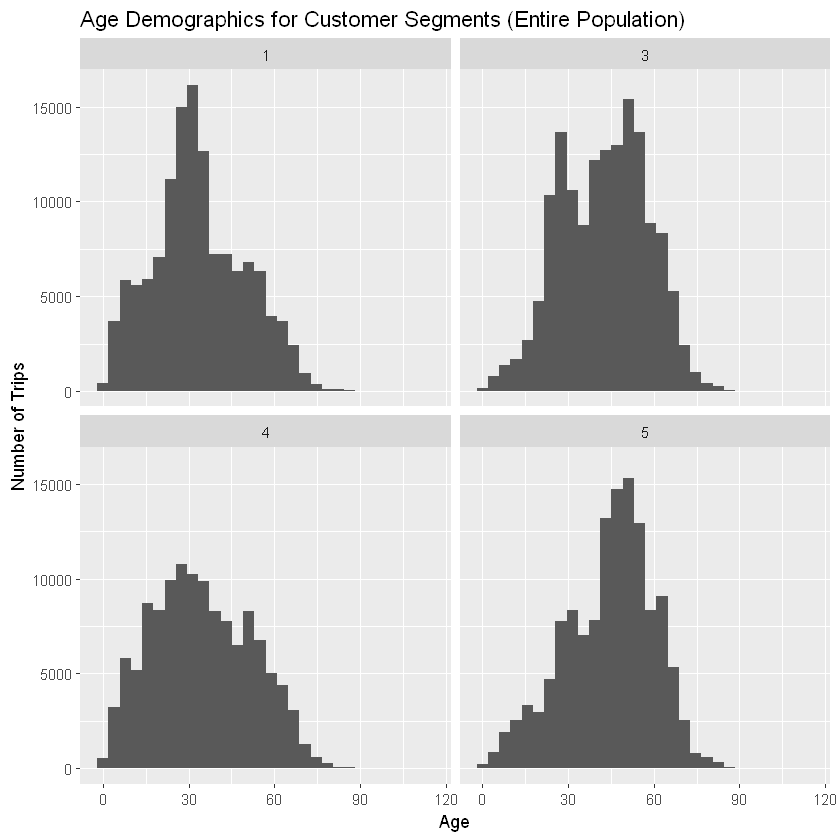

In [20]:
ggplot(data = final_summary_output, aes(final_summary_output$Age)) + 
    geom_histogram() + 
    facet_wrap(. ~ cluster) +
    labs(x = "Age", y = "Number of Trips", title = "Age Demographics for Customer Segments (Entire Population)")